In [27]:
import gymnasium
from gymnasium import spaces
import numpy as np
import copy
class MyTimetable(gymnasium.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 2
        }
    def __init__(self):
        self.seed = 42
        self.start_moment = np.random.randint(400,600)
        self.end_moment = np.random.randint(1200,1290)
        self.driver = 5
        self.headway = self.gen_headway(self.seed)
        self.running = self.gen_running(self.seed)

        self.action_space = spaces.Discrete(2) # 0 for skip,1 for add
        self.observation_space = spaces.Box(low=0, high=1000, shape=(4,), dtype=np.float32) # [0] for time, [1] for driver_index

        predict_arrive = self.start_moment + self.running(self.start_moment)
        is_virtual = 0
        self.state = np.array([self.start_moment,predict_arrive,0,is_virtual])
        self.info = {}
        self.timetable_array = {}
        for i in range(self.driver):
            self.timetable_array[i] = []
        
        if self.state[3] == 0:
            self.timetable_array[0].append(copy.deepcopy(self.state))
        self.track = []
        self.track.append(copy.deepcopy(self.state))
        self.virtual = 0
    
    def gen_headway(self,seed):
        def headway(t):
            np.random.seed(seed)
            return np.random.randint(15,25)
        return headway
    
    def gen_running(self,seed):
        def running(t):
            np.random.seed(seed)
            return np.random.randint(55,70)
        return running
    
    def step(self, action):
        if action == 0:
            # skip
            # start_moment = self.state[0]
            self.state[0] = self.state[0]
            # predict_arrive = self.state[1]
            self.state[1] = self.state[0]
            # driver_index = self.state[2]
            self.state[2] += 1
            # is_virtual = self.state[3]
            self.state[3] = 1
            self.virtual += 1
        else:
            # add
            # start_moment = self.state[0]
            self.state[0] += self.headway(self.state[0])
            # predict_arrive = self.state[1]
            self.state[1] += self.running(self.state[0])*1.2
            # driver_index = self.state[2]
            self.state[2] += 1
            # is_virtual = self.state[3]
            self.state[3] = 0
            

        if self.state[2] == self.driver:
            self.state[2] = 0
        if self.state[3] == 0:
            self.timetable_array[self.state[2]].append(copy.deepcopy(self.state))
        self.track.append(copy.deepcopy(self.state))
        reward = self._get_reward()
        terminated = self._get_terminated()
        terminated = bool(terminated)
        truncated = self._get_truncated()
        truncated = bool(truncated)
        info = {}
        return self.state, reward, terminated,truncated, info
    
    def reset(self,seed=None):
        if seed is not None:
            self.seed = seed
        else:
            self.seed = 42
        self.headway = self.gen_headway(self.seed)
        self.running = self.gen_running(self.seed)
        self.start_moment = np.random.randint(400,600)
        self.end_moment = np.random.randint(1200,1290)
        self.driver = 5
        predict_arrive = self.start_moment + self.running(self.start_moment)
        is_virtual = 0
        self.state = np.array([self.start_moment,predict_arrive,0,is_virtual])
        self.timetable_array = {}
        for i in range(self.driver):
            self.timetable_array[i] = []
        if self.state[3] == 0:
            self.timetable_array[0].append(self.state)
        self.info = {}
        self.track = []
        self.track.append(self.state)
        return self.state,self.info
    
    def render(self, mode='human'):
        print(self.timetable_array)
    
    def close(self):
        return super().close()

    def _get_reward(self):
        # define reward function
        # reward = 0
        if self.end_moment - self.state[1] < 200:
            reward = 1
        elif self.state[1]>self.end_moment:
            reward = 5
        else:
            reward = -(self.end_moment-self.state[1])/100-self.state[3]
        return reward
    
    def is_valid(self):
        # define valid function
        # define the arrival time of the last driver
        for i in range(self.driver):
            trips = self.timetable_array[i]
            # last trips predict arrive time should be less than next trips start time
            for j in range(len(trips)-1):
                if trips[j][1] > trips[j+1][0]+10:
                    return True
        return False
    
    def _get_terminated(self):
        # define terminated function
        if self.state[3] == 0 and self.state[1] > self.end_moment:
            return True
        return False
    
    def _get_truncated(self):
        # define truncated function
        flag = 0
        length = len(self.track)
        while length-flag-1>-1 and self.track[length-flag-1][3] == 1:
            flag += 1
            if flag > self.driver:
                return True
        
        if self.is_valid():
            return True
        return False
    

In [28]:
timetable = MyTimetable()
obs,info = timetable.reset()
state,reward,terminated,truncated,info = timetable.step(timetable.action_space.sample())
log = 0
while not terminated and log<1000:
    timetable.render()
    state,reward,terminated,truncated,info = timetable.step(timetable.action_space.sample())
    if truncated:
        timetable.reset()
    log += 1

{0: [array([600, 713,   1,   0])], 1: [array([600, 713,   1,   0])], 2: [], 3: [], 4: []}
{0: [array([600, 600,   2,   1])], 1: [array([600, 713,   1,   0])], 2: [], 3: [], 4: []}
{0: [array([621, 673,   3,   0])], 1: [array([600, 713,   1,   0])], 2: [], 3: [array([621, 673,   3,   0])], 4: []}
{0: [array([642, 746,   4,   0])], 1: [array([600, 713,   1,   0])], 2: [], 3: [array([621, 673,   3,   0])], 4: [array([642, 746,   4,   0])]}
{0: [array([642, 642,   0,   1])], 1: [array([600, 713,   1,   0])], 2: [], 3: [array([621, 673,   3,   0])], 4: [array([642, 746,   4,   0])]}
{0: [array([642, 642,   1,   1])], 1: [array([600, 713,   1,   0])], 2: [], 3: [array([621, 673,   3,   0])], 4: [array([642, 746,   4,   0])]}
{0: [array([663, 715,   2,   0])], 1: [array([600, 713,   1,   0])], 2: [array([663, 715,   2,   0])], 3: [array([621, 673,   3,   0])], 4: [array([642, 746,   4,   0])]}
{0: [array([684, 788,   3,   0])], 1: [array([600, 713,   1,   0])], 2: [array([663, 715,   2,   0])

In [29]:
from stable_baselines3 import DQN
from stable_baselines3.common import logger
# Train the agent by the stable_baselines3
import os
models_dir = './models/PPO'
logdir = './logs'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

env = MyTimetable()
agent = DQN('MlpPolicy', env, verbose=1,tensorboard_log=logdir)
agent.learn(total_timesteps=100000, log_interval=100,tb_log_name='DQN')
agent.save("DQN_MyTimetable")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/DQN_6


-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 6.49      |
|    ep_rew_mean      | -1.15e+03 |
|    exploration_rate | 0.938     |
| time/               |           |
|    episodes         | 100       |
|    fps              | 7176      |
|    time_elapsed     | 0         |
|    total_timesteps  | 649       |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 6.9       |
|    ep_rew_mean      | -3.42e+03 |
|    exploration_rate | 0.873     |
| time/               |           |
|    episodes         | 200       |
|    fps              | 7368      |
|    time_elapsed     | 0         |
|    total_timesteps  | 1339      |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 7.35      |
|    ep_rew_mean      | -6.39e+03 |
|    exploration_rate | 0.803     |
| time/               |     

In [34]:
env = MyTimetable()
obs,_ = env.reset()
print(obs)
agent = DQN.load('DQN_MyCar.zip',env=env)
terminated = False
while not terminated:
    action,_state = agent.predict(obs)
    obs,rew,terminated,truncated,info = env.step(action)
    env.render()

[579 640   0   0]
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
{0: [array([579, 579,   1,   1])], 1: [], 2: [], 3: [], 4: []}
{0: [array([579, 579,   2,   1])], 1: [], 2: [], 3: [], 4: []}
{0: [array([579, 579,   3,   1])], 1: [], 2: [], 3: [], 4: []}
{0: [array([579, 579,   4,   1])], 1: [], 2: [], 3: [], 4: []}
{0: [array([579, 579,   0,   1])], 1: [], 2: [], 3: [], 4: []}
{0: [array([579, 579,   1,   1])], 1: [], 2: [], 3: [], 4: []}
{0: [array([579, 579,   2,   1])], 1: [], 2: [], 3: [], 4: []}
{0: [array([579, 579,   3,   1])], 1: [], 2: [], 3: [], 4: []}
{0: [array([579, 579,   4,   1])], 1: [], 2: [], 3: [], 4: []}
{0: [array([579, 579,   0,   1])], 1: [], 2: [], 3: [], 4: []}
{0: [array([579, 579,   1,   1])], 1: [], 2: [], 3: [], 4: []}
{0: [array([579, 579,   2,   1])], 1: [], 2: [], 3: [], 4: []}
{0: [array([579, 579,   3,   1])], 1: [], 2: [], 3: [], 4: []}
{0: [array([600, 652,   4,   0])], 1: [], 2: [], 3: [], 4: [array([600, 652,   4,   0]

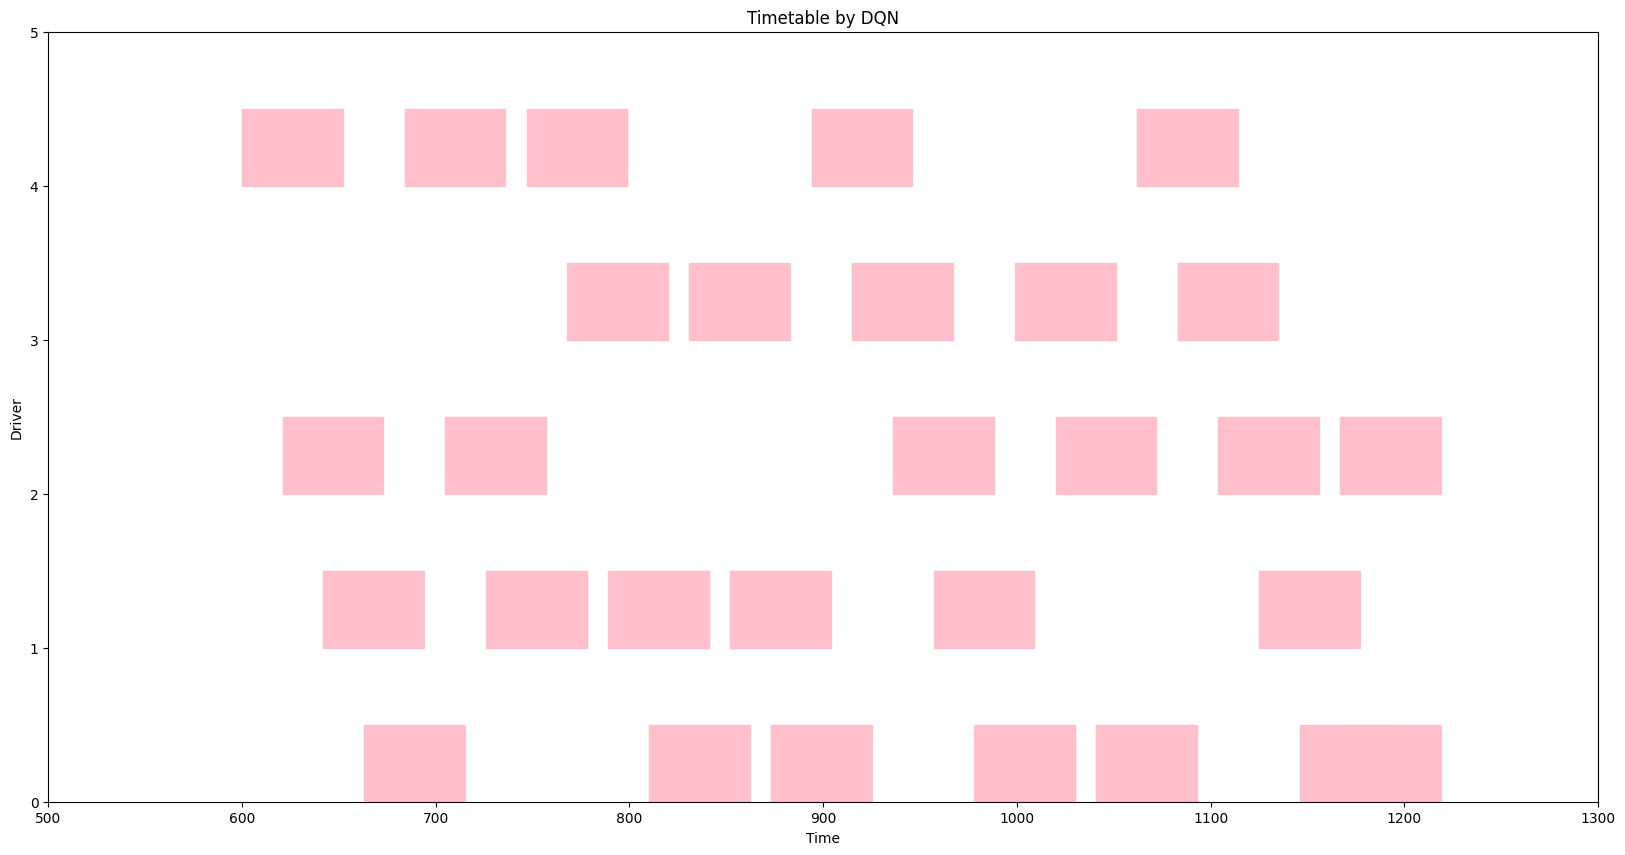

In [40]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np

def visual_timetable(timetable_dict):
    fig,ax = plt.subplots(1,1,figsize=(20,10))
    ax.set_xlim(500,1300)
    ax.set_ylim(0,5)
    ax.set_xlabel('Time')
    ax.set_ylabel('Driver')
    ax.set_title('Timetable by DQN')
    for i in range(len(timetable_dict)):
        for j in range(len(timetable_dict[i])):
            start = timetable_dict[i][j][0]
            end = timetable_dict[i][j][1]
            if timetable_dict[i][j][3] == 0:
                color = 'pink'
            else:
                color = 'b'
            rect = patches.Rectangle((start,i),end-start,0.5,linewidth=1,edgecolor=color,facecolor=color)
            ax.add_patch(rect)
    plt.show()

visual_timetable(env.timetable_array)

